# 5. 📊 MNIST Image Classification

![Status](https://img.shields.io/static/v1.svg?label=Status&message=Finished&color=green)

**Filled notebook:**
[![View filled on Github](https://img.shields.io/static/v1.svg?logo=github&label=Repo&message=View%20On%20Github&color=lightgrey)](https://github.com/bfortuno/Surgical-Phase-Recognition/blob/main/docs/tutorial_notebooks/tutorial5/mnist_cnn.ipynb)
[![Open filled In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/bfortuno/Surgical-Phase-Recognition/blob/main/docs/tutorial_notebooks/tutorial5/mnist_cnn.ipynb)    
**Author:** Benjamin I. Fortuno

In [ ]:
# 📦 Install dependencies
!pip install pytorch-lightning -q
!pip install torchmetrics -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.0/823.0 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 42.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 32.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 26.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 57.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 960.9/960.9 kB 33.3 MB/s eta 0:00:00


In [ ]:
# 📚 Imports
import torch
from torch import nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import pytorch_lightning as pl
from pytorch_lightning import LightningModule, Trainer
import torchmetrics
import matplotlib.pyplot as plt
import numpy as np


The following cell sets up the data pipeline and training configuration for a neural network using the MNIST dataset. It starts by defining **hyperparameters**, which control the training process:

- **Batch Size (BATCH_SIZE = 64):** This determines how many images are processed at once during training. Instead of updating the model after every single image (which is inefficient), we use batches. A batch size of 64 means the model sees 64 images before updating its internal parameters.
  
- **Number of Workers (NUM_WORKERS = 2):** This sets how many subprocesses are used to load the data. Increasing the number of workers can speed up data loading, especially for larger datasets or more complex transformations. Here, 2 workers will load batches in parallel.

- **Learning Rate (LR = 1e-3):** This controls how big the updates to the model’s parameters are after each batch. A learning rate that’s too high might cause the model to miss the optimal solution, while one that’s too low can make training slow. The chosen value (`0.001`) is a common starting point.

- **Epochs (EPOCHS = 5):** One epoch means the model sees the entire training dataset once. Training for 5 epochs means it will repeat this process five times, allowing the model to progressively improve.

The MNIST dataset, which contains grayscale images of handwritten digits (0–9), is loaded and preprocessed using PyTorch’s utilities. The images are converted to tensors and normalized to have values between -1 and 1.

The dataset is then split into three parts:
- **Training Set (80%)**: used to teach the model.
- **Validation Set (20%)**: used to monitor performance during training and prevent overfitting.
- **Test Set**: used only after training to evaluate how well the model generalizes to new data.

Each of these sets is wrapped in a **DataLoader**, which handles batching, shuffling, and parallel data loading.

In [ ]:
# ⚙️ Hyperparameters
BATCH_SIZE = 64        # Number of samples processed before the model is updated (per iteration)
NUM_WORKERS = 2        # Number of subprocesses to use for data loading (0 means load in main process)
LR = 1e-3              # Learning rate used by the optimizer (how big the update steps are)
EPOCHS = 5             # Number of complete passes through the training dataset

# 📥 Dataset and Dataloaders

# Define a transformation pipeline for preprocessing the data:
# 1. Convert images to PyTorch tensors
# 2. Normalize pixel values to range [-1, 1] (original range is [0, 1])
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the MNIST training dataset with transformation applied
# If the dataset is not found locally, it will be downloaded
dataset = datasets.MNIST(root=".", train=True, transform=transform, download=True)

# Load the MNIST test dataset (used after training to evaluate generalization)
mnist_test = datasets.MNIST(root=".", train=False, transform=transform)

# Split the original training dataset into:
# - 80% for training (mnist_train)
# - 20% for validation (mnist_val)
train_len = int(len(dataset) * 0.8)
val_len = len(dataset) - train_len
mnist_train, mnist_val = random_split(dataset, [train_len, val_len])

# Create DataLoader for each split:
# - train_loader: shuffled to introduce randomness in batches
# - val_loader and test_loader: no shuffling needed
train_loader = DataLoader(mnist_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(mnist_val, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)
test_loader = DataLoader(mnist_test, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)

100%|██████████| 9.91M/9.91M [00:00<00:00, 16.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 480kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.54MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.9MB/s]


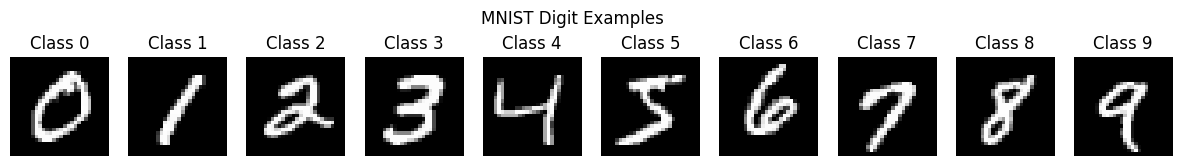

In [ ]:
# 🔍 Visualize examples of each digit
classes = list(range(10))
samples_per_class = {c: None for c in classes}

for img, label in dataset:
    if samples_per_class[label] is None:
        samples_per_class[label] = img
    if all(v is not None for v in samples_per_class.values()):
        break

fig, axes = plt.subplots(1, 10, figsize=(15, 2))
for i, ax in enumerate(axes):
    ax.imshow(samples_per_class[i].squeeze(0), cmap="gray")
    ax.set_title(f"Class {i}")
    ax.axis("off")
plt.suptitle("MNIST Digit Examples")
plt.show()


The following cell defines a **Convolutional Neural Network (CNN)** model using the **PyTorch Lightning** framework, which simplifies training routines and code structure for PyTorch models. The model is designed for **multiclass classification** on the MNIST dataset.

### 🔧 Class Structure

- **`LitCNN(LightningModule)`**: This class extends `LightningModule`, a PyTorch Lightning base class that provides structure to training, validation, and testing steps, as well as optimizer configuration.

### 🧱 Model Architecture

The CNN is defined using `nn.Sequential`:
1. **`Conv2d(1, 32, 3, 1)`**: A convolutional layer with 1 input channel (grayscale image), 32 filters of size 3x3, and stride 1.
2. **`ReLU()`**: Applies the ReLU activation to introduce non-linearity.
3. **`MaxPool2d(2)`**: Downsamples the feature maps by a factor of 2.
4. **`Conv2d(32, 64, 3, 1)`**: Another convolution layer with 64 filters.
5. **`ReLU()`** and **`MaxPool2d(2)`**: Again apply activation and downsampling.
6. **`Flatten()`**: Flattens the 2D feature maps to a 1D vector for fully connected layers.
7. **`Linear(64 * 5 * 5, 128)`**: Fully connected layer with 128 hidden units.
8. **`ReLU()`** and **`Linear(128, 10)`**: Final layer outputs 10 values (one for each MNIST digit class).

### 📊 Accuracy Metric

- Uses `torchmetrics.Accuracy` to compute classification accuracy for 10 classes.

### 🔁 Model Methods

- **`forward(x)`**: Defines the forward pass.
- **`configure_optimizers()`**: Returns the **Adam** optimizer with the previously defined learning rate (`LR`).

### 🚂 Training Step

- **`training_step()`**:
  - Takes a batch of data `(x, y)`
  - Computes predictions (`y_hat`)
  - Calculates **cross-entropy loss**
  - Logs **training loss and accuracy** for each epoch

### 📈 Validation Step

- **`validation_step()`**:
  - Similar to training, but used to monitor performance on the validation set
  - Logs **validation loss and accuracy**

### ✅ Test Step

- **`test_step()`**:
  - Evaluates performance on the test dataset
  - Logs **test loss and accuracy**

In [ ]:
# This class implements a simple Convolutional Neural Network (CNN)
# using the PyTorch Lightning framework, which simplifies training, validation,
# and testing loops by abstracting away boilerplate.

class LitCNN(LightningModule):
    def __init__(self):
        super().__init__()
        self.save_hyperparameters()  # Saves arguments to `hparams` for reproducibility and checkpointing

        # Define the CNN architecture using nn.Sequential for readability.
        # This network is designed for grayscale (1-channel) 28x28 images (e.g., MNIST).
        self.model = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1),  # 1 input channel → 32 output channels, 3x3 kernel
            nn.ReLU(),                                  # Non-linear activation
            nn.MaxPool2d(kernel_size=2),                # Downsample by factor of 2 (output: 13x13)
            nn.Conv2d(32, 64, kernel_size=3, stride=1), # 32 → 64 channels, further feature extraction
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),                # Downsample again (output: 5x5 feature maps)
            nn.Flatten(),                               # Flatten for the fully connected layers
            nn.Linear(64 * 5 * 5, 128),                 # First FC layer: 1600 → 128
            nn.ReLU(),
            nn.Linear(128, 10)                          # Output layer for 10-class classification
        )

        # Accuracy metric for classification, supports multiclass tasks
        self.accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=10)

    def forward(self, x):
        # Forward pass through the model
        return self.model(x)

    def configure_optimizers(self):
        # Use the Adam optimizer with a learning rate defined externally (LR)
        return torch.optim.Adam(self.parameters(), lr=LR)

    def training_step(self, batch, batch_idx):
        # One training step:
        # - batch contains (x, y): input images and their corresponding labels
        # - Compute predictions and loss
        # - Log the loss and accuracy
        x, y = batch
        y_hat = self(x)                                 # Forward pass
        loss = nn.CrossEntropyLoss()(y_hat, y)          # Compute cross-entropy loss
        acc = self.accuracy(y_hat, y)                   # Compute accuracy
        self.log("train_loss", loss, on_step=False, on_epoch=True)  # Log loss for epoch
        self.log("train_acc", acc, on_step=False, on_epoch=True)    # Log accuracy for epoch
        return loss

    def validation_step(self, batch, batch_idx):
        # Validation step is similar to training, but usually no gradients are computed
        # Metrics are logged for monitoring generalization
        x, y = batch
        y_hat = self(x)
        loss = nn.CrossEntropyLoss()(y_hat, y)
        acc = self.accuracy(y_hat, y)
        self.log("val_loss", loss, on_step=False, on_epoch=True)
        self.log("val_acc", acc, on_step=False, on_epoch=True)

    def test_step(self, batch, batch_idx):
        # Test step is similar to validation, used for final evaluation
        x, y = batch
        y_hat = self(x)
        loss = nn.CrossEntropyLoss()(y_hat, y)
        acc = self.accuracy(y_hat, y)
        self.log("test_loss", loss)
        self.log("test_acc", acc)


This code defines a **PyTorch Lightning module** that fine-tunes a **ResNet-50** model for image classification. It's designed to work even with single-channel grayscale images (e.g., MNIST), adapting a powerful pretrained model for simpler datasets.

### 🧠 Model Definition: `LitResNet50`

- Inherits from `LightningModule`, making the training, validation, and testing workflow cleaner and more modular.

- **Constructor Parameters**:
  - `num_classes`: number of output classes (default is 10 for MNIST).
  - `lr`: learning rate for the optimizer.

### 🧩 Model Components

- **`models.resnet50(pretrained=True)`**: Loads a pretrained ResNet-50 model trained on ImageNet. This provides strong feature extraction out of the box.

- **`self.preprocess = nn.Conv2d(1, 3, kernel_size=1)`**:
  - ResNet expects 3-channel RGB images, but MNIST has only 1 channel (grayscale).
  - This 1x1 convolution “copies” the single channel into three, making the data compatible with the ResNet input.

- **`backbone.fc = nn.Linear(backbone.fc.in_features, num_classes)`**:
  - Replaces the final classification layer to output the correct number of classes (10 instead of 1000).

- **`self.model = nn.Sequential(self.preprocess, backbone)`**:
  - Combines the preprocessing layer and modified ResNet into a single model.

- **`torchmetrics.Accuracy`**:
  - Keeps track of classification accuracy across batches during training/validation/testing.

### 🔁 Workflow Methods

- **`forward(x)`**: Standard forward pass through the full model.

- **`configure_optimizers()`**:
  - Returns an **Adam** optimizer with the specified learning rate.

### 🔍 Step Methods

Each of the step methods (`training_step`, `validation_step`, `test_step`) follows the same structure:

1. **Pass input `x` through the model** to get predictions (`logits`).
2. **Compute loss** using `CrossEntropyLoss`.
3. **Compute accuracy** using predicted class probabilities (via `softmax`).
4. **Log metrics** using Lightning’s `self.log()` for easy tracking.

In [ ]:
from torchvision import models

# 🧠 Define a PyTorch LightningModule using a pretrained ResNet-50 as a feature extractor
class LitResNet50(LightningModule):
    def __init__(self, num_classes=10, lr=1e-3):
        super().__init__()
        self.save_hyperparameters()  # Saves num_classes and lr as hyperparameters

        # 🔄 Load a pretrained ResNet-50 model from torchvision
        # This model is originally trained on ImageNet (3-channel, 1000-class)
        backbone = models.resnet50(pretrained=True)

        # 🔁 Adapt input: If using 1-channel images (e.g., MNIST), convert to 3-channel
        # This is done by using a 1x1 convolution that replicates the grayscale image across 3 channels
        self.preprocess = nn.Conv2d(1, 3, kernel_size=1)

        # 🔚 Replace the final fully connected layer to match our number of output classes
        # ResNet-50's original output layer is: nn.Linear(2048, 1000)
        backbone.fc = nn.Linear(backbone.fc.in_features, num_classes)

        # 🧱 Final model: first preprocess (1→3 channels), then forward through modified ResNet-50
        self.model = nn.Sequential(
            self.preprocess,
            backbone
        )

        # 📏 Accuracy metric for multiclass classification
        self.accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)

    def forward(self, x):
        # Forward input through preprocessing and ResNet-50
        return self.model(x)

    def configure_optimizers(self):
        # Use Adam optimizer with learning rate from hparams
        return torch.optim.Adam(self.parameters(), lr=self.hparams.lr)

    def training_step(self, batch, batch_idx):
        # Training logic: compute logits, loss, and accuracy
        x, y = batch
        logits = self(x)
        loss = nn.CrossEntropyLoss()(logits, y)
        acc = self.accuracy(logits.softmax(dim=-1), y)  # Convert logits to probabilities
        self.log("train_loss", loss, on_epoch=True)     # Log loss per epoch
        self.log("train_acc", acc, on_epoch=True)       # Log accuracy per epoch
        return loss

    def validation_step(self, batch, batch_idx):
        # Validation logic (same as training, but without gradient updates)
        x, y = batch
        logits = self(x)
        loss = nn.CrossEntropyLoss()(logits, y)
        acc = self.accuracy(logits.softmax(dim=-1), y)
        self.log("val_loss", loss, on_epoch=True)
        self.log("val_acc", acc, on_epoch=True)

    def test_step(self, batch, batch_idx):
        # Test logic for final evaluation on test set
        x, y = batch
        logits = self(x)
        loss = nn.CrossEntropyLoss()(logits, y)
        acc = self.accuracy(logits.softmax(dim=-1), y)
        self.log("test_loss", loss)
        self.log("test_acc", acc)

### Personalized CNN

In [ ]:
# 🚂 Training
model = LitCNN()
trainer = Trainer(max_epochs=EPOCHS, accelerator="auto", devices="auto")
trainer.fit(model, train_loader, val_loader)

INFO:pytorch_lightning.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name     | Type               | Params | Mode 
--------------------------------------------------------
0 | model    | Sequential         | 225 K  | train
1 | accuracy | MulticlassAccuracy | 0      | train
--------------------------------------------------------
225 K     Trainable params
0         Non-trainable params
225 K     Total params
0.900     Total estimated model params size (MB)
12        Modules in train mode
0         Modules i

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


In [ ]:
# 🧪 Testing
trainer.test(model, test_loader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9872999787330627     │
│         test_loss         │    0.04470616951584816    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.04470616951584816, 'test_acc': 0.9872999787330627}]

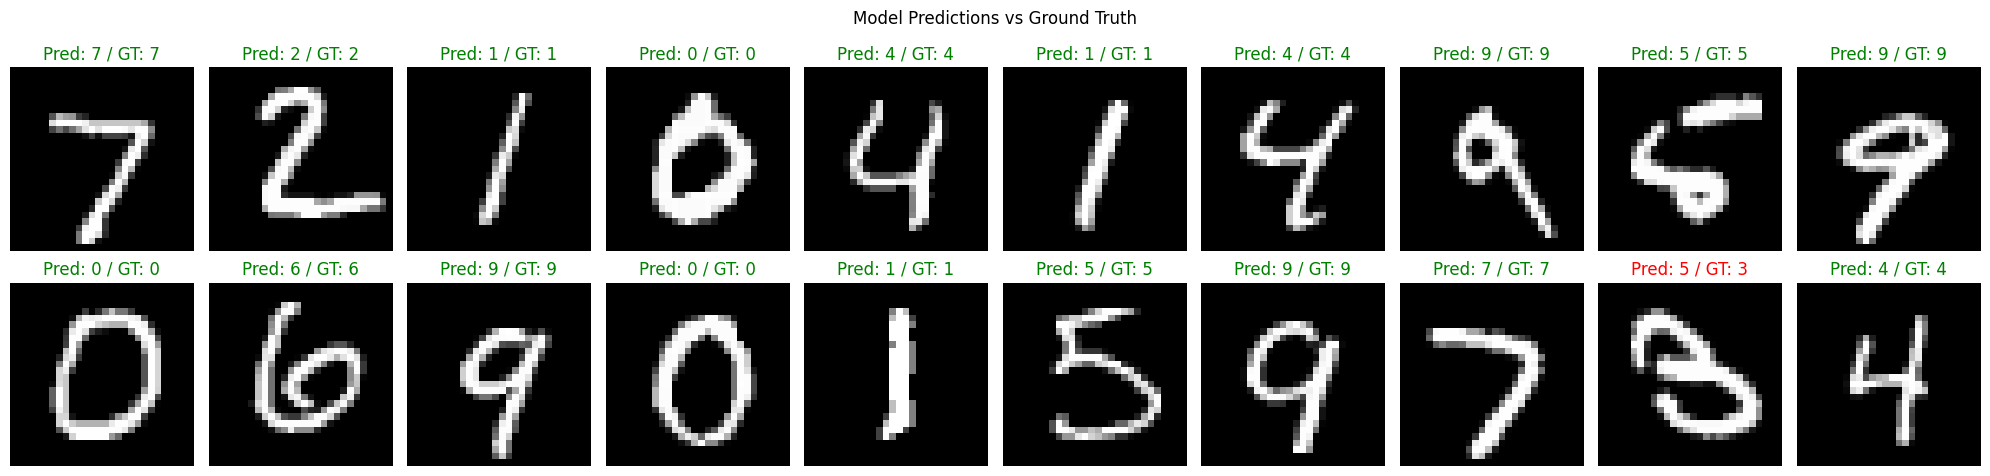

In [ ]:
# 🖼️ Show predictions on test set
def show_predictions(model, loader, num_images=20):
    model.eval()
    imgs_shown = 0
    fig, axes = plt.subplots(2, num_images // 2, figsize=(20, 5))
    axes = axes.flatten()

    with torch.no_grad():
        for batch in loader:
            x, y = batch
            logits = model(x)
            preds = torch.argmax(logits, dim=1)
            for img, pred, label in zip(x, preds, y):
                if imgs_shown >= num_images:
                    break
                ax = axes[imgs_shown]
                ax.imshow(img.squeeze(0), cmap="gray")
                ax.set_title(f"Pred: {pred.item()} / GT: {label.item()}",
                             color="green" if pred == label else "red")
                ax.axis("off")
                imgs_shown += 1
            if imgs_shown >= num_images:
                break
    plt.suptitle("Model Predictions vs Ground Truth")
    plt.tight_layout()
    plt.show()

show_predictions(model, test_loader)


In [ ]:
import time
import numpy as np
import torch

def assess_inference_time_stats(model, loader, num_batches=100):
    model.eval()
    timings = []

    with torch.no_grad():
        for i, (x, _) in enumerate(loader):
            if i >= num_batches:
                break
            start = time.perf_counter()
            _ = model(x)
            end = time.perf_counter()

            elapsed = (end - start) / x.size(0)  # per image
            timings.extend([elapsed] * x.size(0))  # save per image time

    timings = np.array(timings) * 1000  # convert to ms

    mean = np.mean(timings)
    std = np.std(timings)
    median = np.median(timings)
    iqr = np.percentile(timings, 75) - np.percentile(timings, 25)

    print("⏱️ Inference Timing Statistics (per image):")
    print(f"  📊 Mean ± Std:    {mean:.3f} ± {std:.3f} ms")
    print(f"  🧮 Median ± IQR:  {median:.3f} ± {iqr:.3f} ms")

# Run the timing test
assess_inference_time_stats(model, test_loader)


⏱️ Inference Timing Statistics (per image):
  📊 Mean ± Std:    0.350 ± 0.050 ms
  🧮 Median ± IQR:  0.341 ± 0.022 ms


### ResNet50

In [ ]:
# 🚂 Training
model = LitResNet50()
trainer = Trainer(max_epochs=EPOCHS, accelerator="auto", devices="auto")
trainer.fit(model, train_loader, val_loader)

INFO:pytorch_lightning.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type               | Params | Mode 
----------------------------------------------------------
0 | preprocess | Conv2d             | 6      | train
1 | model      | Sequential         | 23.5 M | train
2 | accuracy   | MulticlassAccuracy | 0      | train
----------------------------------------------------------
23.5 M    Trainable params
0         Non-trainable params
23.5 M    Total params
94.114    Total estimated model param

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


In [ ]:
# 🧪 Testing
trainer.test(model, test_loader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9901000261306763     │
│         test_loss         │    0.03428247198462486    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.03428247198462486, 'test_acc': 0.9901000261306763}]

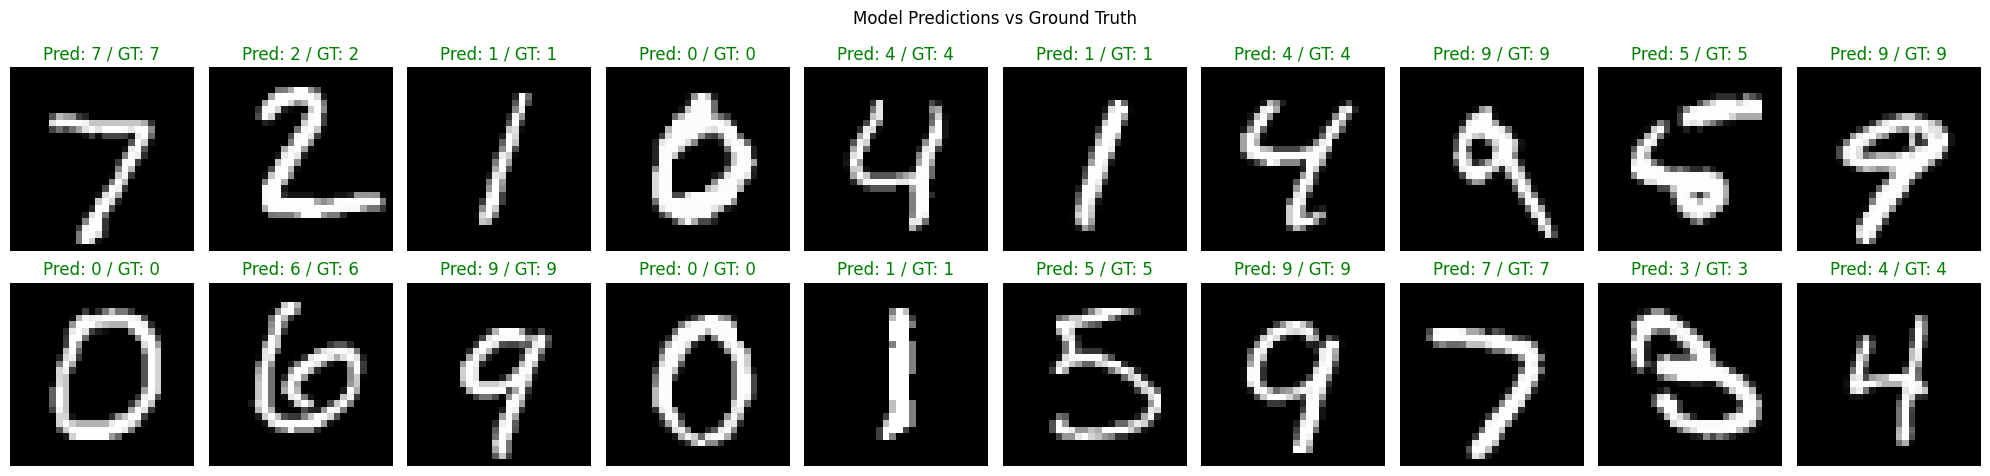

In [ ]:
# 🖼️ Show predictions on test set
def show_predictions(model, loader, num_images=20):
    model.eval()
    imgs_shown = 0
    fig, axes = plt.subplots(2, num_images // 2, figsize=(20, 5))
    axes = axes.flatten()

    with torch.no_grad():
        for batch in loader:
            x, y = batch
            logits = model(x)
            preds = torch.argmax(logits, dim=1)
            for img, pred, label in zip(x, preds, y):
                if imgs_shown >= num_images:
                    break
                ax = axes[imgs_shown]
                ax.imshow(img.squeeze(0), cmap="gray")
                ax.set_title(f"Pred: {pred.item()} / GT: {label.item()}",
                             color="green" if pred == label else "red")
                ax.axis("off")
                imgs_shown += 1
            if imgs_shown >= num_images:
                break
    plt.suptitle("Model Predictions vs Ground Truth")
    plt.tight_layout()
    plt.show()

show_predictions(model, test_loader)


In [ ]:
import time
import numpy as np
import torch

def assess_inference_time_stats(model, loader, num_batches=100):
    model.eval()
    timings = []

    with torch.no_grad():
        for i, (x, _) in enumerate(loader):
            if i >= num_batches:
                break
            start = time.perf_counter()
            _ = model(x)
            end = time.perf_counter()

            elapsed = (end - start) / x.size(0)  # per image
            timings.extend([elapsed] * x.size(0))  # save per image time

    timings = np.array(timings) * 1000  # convert to ms

    mean = np.mean(timings)
    std = np.std(timings)
    median = np.median(timings)
    iqr = np.percentile(timings, 75) - np.percentile(timings, 25)

    print("⏱️ Inference Timing Statistics (per image):")
    print(f"  📊 Mean ± Std:    {mean:.3f} ± {std:.3f} ms")
    print(f"  🧮 Median ± IQR:  {median:.3f} ± {iqr:.3f} ms")

# Run the timing test
assess_inference_time_stats(model, test_loader)


⏱️ Inference Timing Statistics (per image):
  📊 Mean ± Std:    3.977 ± 0.425 ms
  🧮 Median ± IQR:  3.764 ± 0.304 ms
